In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  running_conf = Struct(backend="numba", signature=True, cache =True, precision="double")
  domain = Domain(dim=dim, conf=running_conf)
  ne = Variable(domain=domain)
  u  = Variable(domain=domain)
  v  = Variable(domain=domain)
  w  = Variable(domain=domain)
  
  P = Variable(domain=domain)
  Pinit = 2.0
  cells = domain.cells
  initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, cells.center, Pinit)

  u.face[:] = 2.
  v.face[:] = 0.
  w.face[:] = 0.
  
  u.interpolate_facetocell()
  v.interpolate_facetocell()
  w.interpolate_facetocell()
  return (domain, ne, u, v, w, P)

In [12]:
dim = 2
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
mesh_file = "/home/ayoub.hamou/mesh/square.msh"
mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, ne, u, v, w, P = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 578304
Number of Vertices: 290153
Local domain contruction ...


In [13]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))

host_w_c, d_w_c = create_var(ne.cell)
host_w_ghost, d_w_ghost = create_var(ne.ghost)
host_w_halo, d_w_halo = create_var(ne.halo)
host_w_gradcellx, d_w_gradcellx = create_var(ne.gradcellx)
host_w_gradcelly, d_w_gradcelly = create_var(ne.gradcelly)
host_w_gradcellz, d_w_gradcellz = create_var(ne.gradcellz)
host_psi, d_psi = create_var(ne.psi)
host_cellid, d_cellid = create_var(ne.domain.faces.cellid)
host_faceid, d_faceid = create_var(ne.domain.cells.faceid)
host_namef, d_namef = create_var(ne.domain.faces.name)
host_halofid, d_halofid = create_var(ne.domain.faces.halofid)
host_centerc, d_centerc = create_var(ne.domain.cells.center)
host_centerf, d_centerf = create_var(ne.domain.faces.center)



In [14]:
len(host_psi)

578304

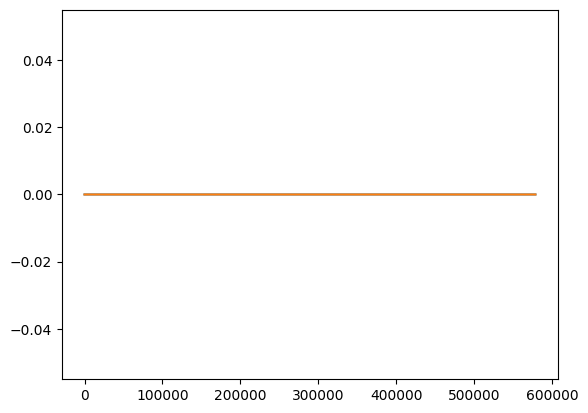

In [15]:
plt.plot(host_psi)
plt.plot(d_psi.copy_to_host())
plt.show()

In [16]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def barthlimiter_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]',
                    w_x:'float[:]', w_y:'float[:]',  w_z:'float[:]', psi:'float[:]', 
                    cellid:'int32[:,:]', faceid:'int32[:,:]', namef:'uint32[:]',
                    halofid:'int32[:]', centerc:'float[:,:]', centerf:'float[:,:]'):
    
    nbelement = len(w_c)
    val  = 1.
    psi[:] = val

    for i in range(nbelement):
        w_max = w_c[i]
        w_min = w_c[i]

        for j in range(faceid[i][-1]):
            face = faceid[i][j]
            if namef[face] == 0 or namef[face] > 10:#
            #11 or namef[face] == 22 or namef[face] == 33 or namef[face] == 44:
                w_max = max(w_max, w_c[cellid[face][0]], w_c[cellid[face][1]])
                w_min = min(w_min, w_c[cellid[face][0]], w_c[cellid[face][1]])
            elif namef[face] == 1 or namef[face] == 2 or namef[face] == 3 or namef[face] == 4:
                w_max = max(w_max,  w_c[cellid[face][0]], w_ghost[face])
                w_min = min(w_min,  w_c[cellid[face][0]], w_ghost[face])
            else:
                w_max = max(w_max,  w_c[cellid[face][0]], w_halo[halofid[face]])
                w_min = min(w_min,  w_c[cellid[face][0]], w_halo[halofid[face]])
        
        for j in range(faceid[i][-1]):
            face = faceid[i][j]

            r_xyz1 = centerf[face][0] - centerc[i][0] 
            r_xyz2 = centerf[face][1] - centerc[i][1]
            
            delta2 = w_x[i] * r_xyz1 + w_y[i] * r_xyz2 
            
            #TODO choice of epsilon
            if np.fabs(delta2) < 1e-8:
                psi_ij = 1.
            else:
                if delta2 > 0.:
                    value = (w_max - w_c[i]) / delta2
                    psi_ij = min(val, value)
                if delta2 < 0.:
                    value = (w_min - w_c[i]) / delta2
                    psi_ij = min(val, value)

            psi[i] = min(psi[i], psi_ij)



In [17]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_barthlimiter_2d = numba.jit(barthlimiter_2d, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_numba_barthlimiter_2d():
  numba_barthlimiter_2d(
    host_w_c,
    host_w_ghost,
    host_w_halo,
    host_w_gradcellx,
    host_w_gradcelly,
    host_w_gradcellz,
    host_psi,
    host_cellid,
    host_faceid,
    host_namef,
    host_halofid,
    host_centerc,
    host_centerf,
  )


In [18]:
#time taken by cpu_numba_barthlimiter_2d

initialisation_gaussian_2d(ne.cell, u.cell, v.cell, P.cell, domain.cells.center, 2.0)

%timeit cpu_numba_barthlimiter_2d()

54.5 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
host_faceid.shape

(578304, 4)

In [20]:
@cuda.jit
def kernel_barthlimiter_2d(w_c:'float[:]', w_ghost:'float[:]', w_halo:'float[:]',
                    w_x:'float[:]', w_y:'float[:]',  w_z:'float[:]', psi:'float[:]', 
                    cellid:'int32[:,:]', faceid:'int32[:,:]', namef:'uint32[:]',
                    halofid:'int32[:]', centerc:'float[:,:]', centerf:'float[:,:]'):
    
    i = cuda.grid(1)
    
    if i > w_c.shape[0]:
        return

    val  = 1.
    psi[i] = val

 
    
    w_max = w_c[i]
    w_min = w_c[i]


    for j in range(faceid[i][-1]):
        face = faceid[i][j]
        if namef[face] == 0 or namef[face] > 10:
        #11 or namef[face] == 22 or namef[face] == 33 or namef[face] == 44:
            w_max = max(w_max, w_c[cellid[face][0]], w_c[cellid[face][1]])
            w_min = min(w_min, w_c[cellid[face][0]], w_c[cellid[face][1]])
        elif namef[face] == 1 or namef[face] == 2 or namef[face] == 3 or namef[face] == 4:
            w_max = max(w_max,  w_c[cellid[face][0]], w_ghost[face])
            w_min = min(w_min,  w_c[cellid[face][0]], w_ghost[face])
        else:
            w_max = max(w_max,  w_c[cellid[face][0]], w_halo[halofid[face]])
            w_min = min(w_min,  w_c[cellid[face][0]], w_halo[halofid[face]])
    
    for j in range(faceid[i][-1]):
        face = faceid[i][j]

        r_xyz1 = centerf[face][0] - centerc[i][0] 
        r_xyz2 = centerf[face][1] - centerc[i][1]
        
        delta2 = w_x[i] * r_xyz1 + w_y[i] * r_xyz2 
        
        #TODO choice of epsilon
        #!np.fabs
        #!if abs(delta2) < 1e-8:
        psi_ij = 1.

        if abs(delta2) >= 1e-8:
            if delta2 > 0.:
                value = (w_max - w_c[i]) / delta2
                psi_ij = min(val, value)
            if delta2 < 0.:
                value = (w_min - w_c[i]) / delta2
                psi_ij = min(val, value)

        psi[i] = min(psi[i], psi_ij)





def cuda_numba_barthlimiter_2d():
  nb_element = len(host_w_c)
  nb_threads = 32
  nb_blocks = nb_element // 32 + 1


  kernel_barthlimiter_2d[nb_blocks, nb_threads](
    d_w_c,
    d_w_ghost,
    d_w_halo,
    d_w_gradcellx,
    d_w_gradcelly,
    d_w_gradcellz,
    d_psi,
    d_cellid,
    d_faceid,
    d_namef,
    d_halofid,
    d_centerc,
    d_centerf,
  )
  cuda.synchronize()

test_time(700, cuda_numba_barthlimiter_2d)

3.22683 ms


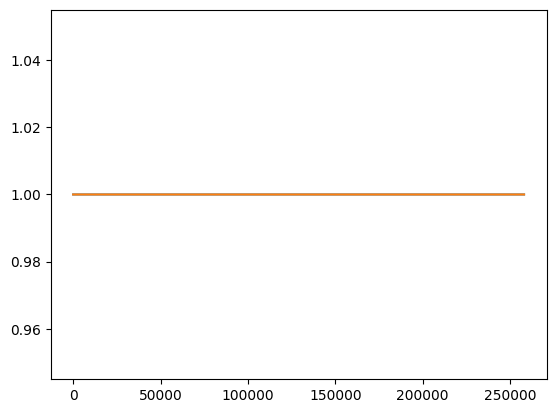

In [11]:
def verify(a, b):
  b = b.copy_to_host()
  plt.plot(a)
  plt.plot(b)

  #assert
  np.testing.assert_almost_equal(a, b, decimal=2, )
  plt.show()

verify(host_psi, d_psi)